In [4]:
import os
import shutil
import glob
from operator import ne
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt   
%matplotlib inline

from google.colab import drive
from google.colab import files
from google.colab import files

drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.9 MB 16.1 MB/s 
     |████████████████████████████████| 1.4 MB 47.6 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 190 kB 57.9 MB/s 
     |████████████████████████████████| 3.6 MB 53.2 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 138 kB 71.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 843 kB 59.7 MB/s 
     |████████████████████████████████| 42 kB 856 kB/s 
     |████████████████████████████████| 69 kB 7.4 MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=625bd5cb0b9188566bbd16b43991461ca6dfc57b1ad990a6a621b92ef759753e
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Succes

In [6]:
import numpy as np
import math
import os
import csv
import glob
import cv2
import tensorflow as tf
import h5py as h5py
from scipy.spatial import distance
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model, load_model

In [7]:
import imageio
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks

Defining functions to extract features from facial landmarks

In [6]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye


In [35]:
kss_path = '/content/drive/MyDrive/DDDS/dataframes'
data_path= '/content/drive/MyDrive/DDDS/dataset/faces'
root_path= '/content/drive/MyDrive/DDDS/dataset'
features_path = '/content/drive/MyDrive/DDDS/dataset/features'

os.chdir(root_path)
files = [f for f in os.listdir(data_path) if '.zip' in f]
files.sort()

In [109]:
for file in files[4:]:
  file_name = file[:-4]
  print(f' unziping {file_name}')
  kss_file = 'image_kss_'+ file_name + '.csv'
  print(f'loading {kss_file} file ...')
  print("")
  ## unziping the face folder
  command = f'unzip faces/{file_name}.zip -d faces/'
  os.system(command)

  ## kss dataframe reading and arrangement
  kss_df = pd.read_csv(f'{kss_path}/{kss_file}')
  kss_df.drop(columns = ['Unnamed: 0', 'time_points', 'frame_id'], inplace = True, axis = 1)
  kss_df.dropna(inplace = True)
  kss_df['kss_value'] = kss_df['kss_value'].astype(int)

  ## listing the faces 
  faces = os.listdir(os.path.join(data_path, file_name))
  faces.sort()
  print('The total number of faces are', len(faces))
  print("") 
  count = 0
  landmarks_data = []
  labels = []
  features = []
  face_folder = os.path.join(data_path, file_name)
  for face in faces:
    if any(kss_df['face_frame_id'] == face):
      image = cv2.imread(os.path.join(face_folder ,face))
      landmarks = extract_face_landmarks(image)
      if landmarks is not None and sum(sum(landmarks)) != 0:
          # print(landmarks.shape)
          count += 1
          landmarks_data.append(landmarks)
          row = kss_df.loc[kss_df['face_frame_id'] == face]
          labels.append(row['kss_value'].values[0])
          print(count)

  landmarks_data = np.array(landmarks_data)
  labels = np.array(labels)
  for data in landmarks_data:
      
      eye = data[36:68] # landmarks related to eyes and mouth
      ear = eye_aspect_ratio(eye)
      mar = mouth_aspect_ratio(eye)
      cir = circularity(eye)
      mouth_eye = mouth_over_eye(eye)
      features.append([ear, mar, cir, mouth_eye])

  features = np.array(features)
  print(features.shape)
  print("")

  ## saving 
  if np.size(landmarks_data) != 0:
    np.save(open(f'{features_path}/landmarks_data_{file_name}.npy', 'wb'), landmarks_data)
    np.save(open(f'{features_path}/features_{file_name}.npy', 'wb'), features)
    np.save(open(f'{features_path}/labels_{file_name}.npy', 'wb'), labels)

  if np.size(features) != 0:
    features_dict = {'ear': features[:, 0], 'mar': features[:,1],
                     'cir': features[:, 2], 'mouth_eye': features[:, 3],
                     'kss_val': labels}
    features_df = pd.DataFrame.from_dict(features_dict)
    features_df.to_csv(f"{features_path}/features_df_{file_name}.csv")
    pd.DataFrame(features).to_csv(f"{features_path}/features_{file_name}.csv")
    pd.DataFrame(labels).to_csv(f"{features_path}/labeles_{file_name}.csv")

  print('Removing', face_folder)
  try:
      shutil.rmtree(face_folder)
  except OSError as e:
      print("Error: %s - %s." % (e.filename, e.strerror))
  print("******************************************************************")
  print("******************************************************************")

 unziping 2021-11-04_11-01-00_eca
loading image_kss_2021-11-04_11-01-00_eca.csv file ...

The total number of faces are 4061



/usr/local/lib/python3.7/dist-packages/mlxtend/image/extract_face_landmarks.py:61: UserWarning: No face detected.
  warnings.warn('No face detected.')


Streaming output truncated to the last 5000 lines.
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669

In [204]:
features_path = os.path.join(root_path, 'normalized_features')
features_dfs_list = [f for f in os.listdir(features_path)]

cols = ['ear', 'mar', 'cir', 'mouth_eye', 'kss_val', 'ID']
combined_df = pd.DataFrame(columns = cols)
df_alert_first3_total = pd.DataFrame(columns = cols)
print("----------------------")

for f_df in features_dfs_list:
  file_name = f_df[12:-4]
  df = pd.read_csv(f'{features_path}/{f_df}')
  df = df.drop(["Unnamed: 0"],axis=1)
  df['ID'] = file_name
  # calculating the average of features in first three alert frames (if they exist)
  if len(df[df["kss_val"]==0]) != 0:
    print('adding', f_df)
    combined_df = pd.concat([combined_df, df], ignore_index=True )
    ## alert df
    df_alert = df[df["kss_val"]==0]
    steps = df_alert.shape[0] + 1
    df_alert1 = df_alert.iloc[0::steps, :]
    df_alert2 = df_alert.iloc[1::steps, :]
    df_alert3 = df_alert.iloc[2::steps, :]
    df_alert_first3 = pd.concat([df_alert1,df_alert2,df_alert3],)
    df_alert_first3 = df_alert_first3.sort_index()
    df_alert_first3_total = pd.concat([df_alert_first3_total, df_alert_first3])

df_alert_first3_total.shape

----------------------
adding features_df_2021-10-26_13-32-50_c27.csv
adding features_df_2021-10-28_15-04-13_1c3.csv
adding features_df_2021-11-02_15-23-39_1c3.csv
adding features_df_2021-11-05_13-59-29_ea9.csv
adding features_df_2021-11-17_10-58-38_e99.csv
adding features_df_2021-11-18_13-21-41_e99.csv
adding features_df_2021-11-22_11-26-24_ea9.csv
adding features_df_2021-11-24_11-01-03_eca.csv
adding features_df_2021-11-24_15-36-04_e99.csv
adding features_df_2021-11-26_12-34-32_1c3.csv
adding features_df_2021-11-26_15-16-28_ea9.csv
adding features_df_2021-11-29_13-48-17_eca.csv
adding features_df_2021-12-01_13-20-00_e99.csv
adding features_df_2021-12-07_14-35-11_ea9.csv


(31, 6)

In [208]:
#Based on the first 3 "Alert" frames, calculating  mean and std for each feature
df_means = df_alert_first3_total.groupby("ID")["ear","mar","cir","mouth_eye"].mean()
df_std = df_alert_first3_total.groupby("ID")["ear","mar","cir","mouth_eye"].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [209]:
#Functions for the baseline mean and std for each feature 
def mean_EAR(ID):
    return df_means.loc[ID]["ear"]

def mean_MAR(ID):
    return df_means.loc[ID]["mar"]

def mean_Circularity(ID):
    return df_means.loc[ID]["cir"]

def mean_MOE(ID):
    return df_means.loc[ID]["mouth_eye"]


def std_EAR(ID):
    return df_std.loc[ID]["ear"]

def std_MAR(ID):
    return df_std.loc[ID]["mar"]

def std_Circularity(ID):
    return df_std.loc[ID]["cir"]

def std_MOE(ID):
    return df_std.loc[ID]["mouth_eye"]


In [210]:
df = combined_df.copy()
#Adding ID-wise mean and std for each feature to each row in the original dataframe
df["ear_mean"] = df["ID"].apply(mean_EAR)
df["mar_mean"] = df["ID"].apply(mean_MAR)
df["cir_mean"] = df["ID"].apply(mean_Circularity)
df["MOE_mean"] = df["ID"].apply(mean_MOE)

df["ear_std"] = df["ID"].apply(std_EAR)
df["mar_std"] = df["ID"].apply(std_MAR)
df["cir_std"] = df["ID"].apply(std_Circularity)
df["MOE_std"] = df["ID"].apply(std_MOE)

In [211]:
#Calculating normalised features for each row in the original dataframe
df["EAR_N"] = (df["ear"]-df["ear_mean"])/ df["ear_std"]
df["MAR_N"] = (df["mar"]-df["mar_mean"])/ df["mar_std"]
df["Cir_N"] = (df["cir"]-df["cir_mean"])/ df["cir_std"]
df["MOE_N"] = (df["mouth_eye"]-df["MOE_mean"])/ df["MOE_std"]
print(df.shape)
df.dropna(inplace = True)
print(df.shape)

In [215]:
#Saving the file to a CSV with all the information
df.to_csv(f'{features_path}/dataset_allinfo.csv', index=False)

#Saving the file to a CSV with all the features
df_main = df.drop(["ear_mean","mar_mean","cir_mean","MOE_mean","ear_std","mar_std","cir_std","MOE_std"],axis=1)
df_main.to_csv(f'{features_path}/dataset_features.csv',index=False)

# Calssification Models

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings

In [23]:
root_path= '/content/drive/MyDrive/DDDS/dataset'
features_path = os.path.join(root_path, 'normalized_features')
df = pd.read_csv(f'{features_path}/dataset_features.csv',sep=',')
df.head()
y = df['kss_val']
print(y.shape)
X = df[['EAR_N', 'MAR_N', 'Cir_N', 'MOE_N']]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1)
print(X_test.shape)
print(y_test.shape)


(10710,)
(10710, 4)
(3213, 4)
(3213,)


## Logistic regression

In [53]:
from sklearn.model_selection import cross_validate
logisticRegr = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', max_iter = 1000)
print(clf.classes_)
cv_results = cross_validate(logisticRegr, X_train, y_train, cv = 10, scoring = 'f1_macro')
linear_reg_score = cv_results['test_score'].mean()
print(linear_reg_score)

clf = logisticRegr.fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)
acc1 = accuracy_score(y_test, y_pred_1)
f1_score_1 = metrics.f1_score(y_test, y_pred_1, average= 'macro')
print([acc1,f1_score_1])
# print(confusion_matrix(y_test, y_pred_1))

[0 2 3 4 5 6 7 8 9]


NameError: ignored

## KNN

In [86]:
acc2_list = []
f1_score2_list = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    y_score_2 = neigh.predict_proba(X_test)[:,1]
    acc2_list.append(accuracy_score(y_test, pred_KN))
    f1_score2_list.append(metrics.f1_score(y_test, pred_KN, average= 'macro'))
acc2_list.index(max(acc2_list))+1

26

In [88]:
neigh = KNeighborsClassifier(n_neighbors=acc2_list.index(max(acc2_list))+1)
neigh.fit(X_train, y_train) 
pred_KN = neigh.predict(X_test)
acc2 = accuracy_score(y_test, pred_KN)
f1_score_2 = metrics.f1_score(y_test, pred_KN, average= 'macro')
print([acc2, f1_score_2])
print(confusion_matrix(y_test, pred_KN))

[0.3968253968253968, 0.2852153289154443]
[[  0   0   9   0   0   0   0   0   2]
 [  1  44  55   0  43  29  19   5   4]
 [  0  30 127   0  89  48  23  30  24]
 [  0   2  13   2  13  68   0  11  96]
 [  0  29  70   0 229  98  46  41  27]
 [  0  24  33   3  57 232   2   6 127]
 [  0  19  63   0  87  38  93  34  31]
 [  0   3  34   0  79   1  33  80 106]
 [  0   5  24   4  23  90  21  66 468]]


## MLP

In [91]:
from sklearn.neural_network import MLPClassifier

F1_score_3_list = []
acc3_list = []
mlp = []

hidden_units = [10,20,30,40,50,60,70]
optimizer = ['sgd','adam','lbfgs']
activation = ['logistic','tanh','relu']
for j in activation:
    for i in optimizer:
        for k in hidden_units:
              clf_MLP = MLPClassifier(hidden_layer_sizes= k, max_iter = 1000,
                                      activation =  j, solver= i)
              clf_MLP.fit(X_train, y_train)
              pred_MLP = clf_MLP.predict(X_test)
              acc3_list.append(accuracy_score(y_test,pred_MLP))
              F1_score_3_list.append(metrics.f1_score(y_test, pred_MLP, average = 'macro'))
              mlp.append([j,i,k])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_m

KeyboardInterrupt: ignored

In [92]:
print("Best Accuracy: ", max(acc3_list))
min_index = acc3_list.index(max(acc3_list))
print("Best Combination:", mlp[min_index])

Best Accuracy:  0.41954559601618424
Best Combination: ['tanh', 'lbfgs', 50]


In [93]:
clf_MLP = MLPClassifier(hidden_layer_sizes= mlp[min_index][2], activation =  mlp[min_index][0], solver= mlp[min_index][1])
clf_MLP.fit(X_train, y_train)
pred_MLP = clf_MLP.predict(X_test)
acc3 = accuracy_score(y_test,pred_MLP)
f1_score_3 = metrics.f1_score(y_test, pred_MLP, average = 'macro')
print([acc3,f1_score_3])
print(confusion_matrix(y_test, pred_MLP))

[0.3983815748521631, 0.27399524510869266]
[[  0   0   9   0   0   0   1   0   1]
 [  1  46  52   0  42  37  19   1   2]
 [  1  21  93   0 108  74  26  18  30]
 [  0   3   6   0   2  66   0  12 116]
 [  1  15  59   0 238 144  33  17  33]
 [  0  17  14   0  33 276   3   0 141]
 [  3  15  65   0 119  50  71  25  17]
 [  7   1  25   0  91   0  40  55 117]
 [  2   0  20   0  23  95  15  45 501]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier
acc4=[]
max_depth = []
for i in [2,3,4,5,6,7,8,9,10]:
    clf_DT = DecisionTreeClassifier(random_state=0, max_depth = i)
    clf_DT.fit(X_train, y_train)
    pred_DT = clf_DT.predict(X_test)
    acc4.append(accuracy_score(pred_DT, y_test))
    max_depth.append(i)
print (max(acc4))
best_depth_4 = max_depth[acc4.index(max(acc4))]
print(best_depth_4)

0.39589169000933705
5


In [100]:
clf_DT = DecisionTreeClassifier(random_state=0, max_depth = best_depth_4)
clf_DT.fit(X_train, y_train)
pred_DT = clf_DT.predict(X_test)

acc4 = accuracy_score(y_test, pred_DT)
f1_score_4 = metrics.f1_score(y_test, pred_DT, average = 'macro')
print([acc4,f1_score_4])
print(confusion_matrix(y_test, pred_DT))

[0.39589169000933705, 0.23201132895040233]
[[  0   0   7   0   1   2   0   0   1]
 [  0   1  95   2  19  67  11   1   4]
 [  0   0 154   2  51  93  17   0  54]
 [  0   0  10   2   1  87   0   0 105]
 [  0   0 123   2 181 171  30   0  33]
 [  0   0  24   4   1 342   0   0 113]
 [  0   0 109   0  95  62  78   0  21]
 [  0   0  69   1  90   1  37   3 135]
 [  0   0  30   2  34 101  18   5 511]]


## Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
acc5=[]
max_depth = []
for i in range(1,10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train) 
    pred_RF = clf_RF.predict(X_test)
    acc5.append(accuracy_score(pred_RF, y_test))
    max_depth.append(i)
print (max(acc5))
best_depth_5 = max_depth[acc5.index(max(acc5))]
print(best_depth_5)

0.4282601929660753
8


In [102]:
clf_RF = RandomForestClassifier(max_depth=best_depth_5)
clf_RF.fit(X_train, y_train) 
pred_RF = clf_RF.predict(X_test)
acc5 = accuracy_score(y_test, pred_RF)
f1_score_5 = metrics.f1_score(y_test, pred_RF, average = None)
print([acc5,f1_score_5])
print(confusion_matrix(y_test, pred_RF))

feature_importances = pd.DataFrame(clf_RF.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

[0.4239028944911298, array([0.        , 0.24548736, 0.35908596, 0.01895735, 0.42540905,
       0.45208845, 0.30383973, 0.20041754, 0.62874251])]
[[  0   0   9   0   0   0   0   1   1]
 [  0  34  67   0  30  52  13   0   4]
 [  0  12 165   0  48  78  28   8  32]
 [  0   1  10   2   3  72   0  12 105]
 [  0  12  93   1 221 137  37   9  30]
 [  0   9  26   1  32 276   3   5 132]
 [  0   7  91   1  78  50  91  23  24]
 [  0   2  57   1  68   3  41  48 116]
 [  0   0  30   0  19  69  21  37 525]]


In [103]:
feature_importances

,importance
MOE_N,0.376985
MAR_N,0.265900
Cir_N,0.187757
EAR_N,0.169358


## XGBClassifier

In [105]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier

clf_XGB = XGBClassifier()
clf_XGB.fit(X_train, y_train)
pred_XGB = clf_XGB.predict(X_test)
acc6 = accuracy_score(y_test,pred_XGB)
f1_score_6 = metrics.f1_score(y_test, pred_XGB, average = 'macro')
print([acc6, f1_score_6])
print(confusion_matrix(y_test, pred_XGB))

[0.41612200435729846, 0.27923003775863386]
[[  0   1   7   0   0   1   0   1   1]
 [  1  22  91   0  27  41  11   3   4]
 [  0  10 157   0  54  72  33   7  38]
 [  0   1   8   2   4  68   0   8 114]
 [  0   5 103   0 192 139  54  16  31]
 [  0   2  34   2  20 267   0   3 156]
 [  0   6  98   0  70  38 105  14  34]
 [  1   0  48   0  68   1  47  42 129]
 [  0   0  29   0  14  59  22  27 550]]


## CNN

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout
## Create Model ##

model = Sequential()

model.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (4,1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))



## Compile Model ##
optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())
## Train Model and Check Validation Accuracy ##
X_train_reshaped = np.expand_dims(X_train, axis=2)
print(X_train_reshaped.shape)
X_test_reshaped = np.expand_dims(X_test, axis=2)
print(X_test_reshaped.shape)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2, 64)             256       
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 32)                4128      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                170       
                                                                 
Total params: 5,082
Trainable params: 5,082
Non-traina

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [127]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
count_classes = y_train_cat.shape[1]
print(count_classes)
y_trian_cat = to_categorical(y_train, num_classes= 10)
y_test_cat = to_categorical(y_test, num_classes= 10)

10


In [134]:
root_path = '/content/drive/MyDrive/DDDS/'
os.chdir(root_path)
!pwd

/content/drive/MyDrive/DDDS


In [135]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
metric = 'val_accuracy'

checkpoint = ModelCheckpoint(filepath="models/CNN_model_features.h5",
                             monitor = metric,
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq= 2)

early = EarlyStopping(monitor=metric, patience=20,
                      verbose=1, mode='auto')

In [136]:
hist = model.fit(X_train_reshaped, y_train_cat,
                 validation_split = .2, epochs = 100,
                callbacks=[checkpoint, early],
                              verbose = 1)
model.save("models/CNN_model_features.h5")

Epoch 1/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6383 - accuracy: 0.3288 - val_loss: 1.5852 - val_accuracy: 0.3360
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6434 - accuracy: 0.3302 - val_loss: 1.5851 - val_accuracy: 0.3393
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6344 - accuracy: 0.3403 - val_loss: 1.5845 - val_accuracy: 0.3387
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6336 - accuracy: 0.3358 - val_loss: 1.5839 - val_accuracy: 0.3400
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6348 - accuracy: 0.3400 - val_loss: 1.5835 - val_accuracy: 0.3393
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6380 - accuracy: 0.3323 - val_loss: 1.5834 - val_accuracy: 0.3387
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6345 - accuracy: 0.3362 - val_loss: 1.5831 - val_accuracy: 0.3380

In [139]:
model.save("models/CNN_model_features.h5")

In [137]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.1, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f186a22d550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f186a249c50>)

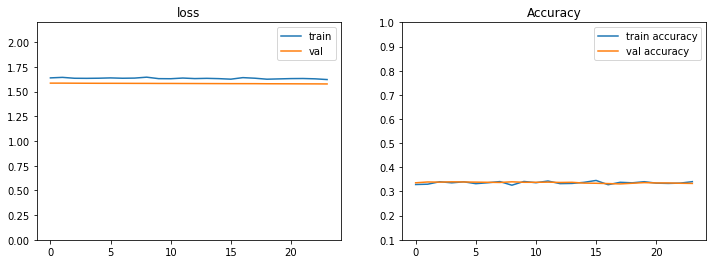

In [138]:
plot_history(hist, title='', axs=None, exp_name="")

In [152]:
# round probabilities to class labels
pred_cnn = [pred_.argmax() for pred_ in model.predict(X_test)]
pred_cnn
acc7 = accuracy_score(y_test, np.array(pred_cnn))
acc7
f1_score_7 = metrics.f1_score(y_test, np.array(pred_cnn), average = 'macro')
print([acc7,f1_score_7])
print(confusion_matrix(y_test, pred_cnn))

[0.3638344226579521, 0.16380719513428701]
[[  0   0   0   0   7   0   0   0   4]
 [  0   0  30   0 144  11   0   9   6]
 [  0   0  10   0 228  50   0   8  75]
 [  0   0   1   0  17  40   0   0 147]
 [  0   0  14   0 383  93   0  13  37]
 [  0   0  13   0 103 156   0   0 212]
 [  0   0  14   0 250  23   0  41  37]
 [  0   0   1   0 172   0   0  13 150]
 [  0   0   1   0  54  30   0   9 607]]


# Comparison between different modeling 

,Accuracy
Model,
Logistic Regression,0.214130
KNN,0.396825
MLP,0.398382
Decision Tree,0.395892
Random Forest,0.423903
XGB Boosting,0.416122
CNN,0.363834


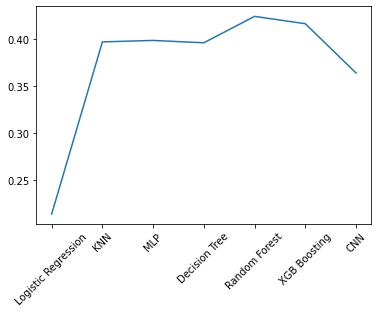

In [153]:
acc_total = {'Model':['Logistic Regression', 'KNN', 'MLP','Decision Tree',
                      'Random Forest', 'XGB Boosting','CNN'],
        'Accuracy':[acc1, acc2, acc3, acc4, acc5, acc6, acc7]}
        
acc_total=pd.DataFrame(acc_total)
acc_total=acc_total.set_index('Model')
acc_total
plt.plot(acc_total['Accuracy'])
plt.xticks(rotation=45)
acc_total